In [1]:
import torch
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.optim as optim
import optuna
from train import Trainer
from dataset import DataPreparation
from models import *
from eval import evaluate_model
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')


/home/tari/.virtualenvs/ner/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Config:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Thiết bị sử dụng (cuda hoặc cpu)
        self.train_dir = "/home/tari/Documents/BackUp_AI_Class/day04/exercise/dataset/train/"  # Đường dẫn đến dữ liệu huấn luyện
        self.test_dir = '/home/tari/Documents/BackUp_AI_Class/day04/exercise/dataset/test/'
        self.num_classes = None
        self.class_names = None
        self.batch_size = 64
        self.max_epochs = 5
        self.patience = 3
        self.lr = 0.0001
        self.beta1 = 0.95
        self.beta2 = 0.993

In [3]:
# Loss
criterion = nn.CrossEntropyLoss()

In [4]:
cfg = Config()
data_preparation = DataPreparation(
    cfg = cfg
    )

Số lượng lớp: 6
Tên lớp: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Ánh xạ từ tên lớp sang chỉ số: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Number of train:  14034
Number of test:  3000


In [5]:
def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [2, 4, 6, 8, 16, 32])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    beta1 = trial.suggest_float("beta1", 0.9, 0.99, step=0.01)
    beta2 = trial.suggest_float("beta2", 0.99, 0.999, step=0.001)
    
    # Update configs
    cfg.beta1 = beta1
    cfg.beta2 = beta2
    cfg.batch_size = batch_size
    cfg.lr = learning_rate
    

    # Create dataloader
    data_preparation.create_data_loaders()
    trainloader = data_preparation.trainloader
    testloader = data_preparation.testloader
    cfg.num_classes = data_preparation.num_classes
    cfg.class_names = data_preparation.classes_name
    
    # Create Model
    model = mobilenetv3_frozen(cfg.num_classes)

    # Create Trainer
    trainer = Trainer(
        model = model, 
        train_loader=trainloader, 
        test_loader=testloader,
        cfg=cfg
    )
    
    optimizer = optim.Adam(model.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))

    # Training
    trainer.train(
        optimizer=optimizer, 
        scheduler=None,
        criterion=criterion
    )
    best_model = trainer.model_best_loss
    all_predictions, all_true_labels = evaluate_model(
        model=best_model, 
        test_dataloader = testloader, 
        device = cfg.device, 
        class_names = data_preparation.classes_name
    )
    f1 = f1_score(all_true_labels, all_predictions, average='weighted')
    return f1


[I 2023-09-30 10:08:39,238] A new study created in memory with name: Image Classificaion with Transfer Leanring
epochs:  20%|██        | 1/5 [02:08<08:35, 128.91s/it]

Epoch 1/5 - Train Loss: 12.8057 - Test Loss: 0.6450 - Train F1: 0.7203 - Test F1: 0.7867


epochs:  40%|████      | 2/5 [03:25<04:54, 98.17s/it] 

Epoch 2/5 - Train Loss: 0.7079 - Test Loss: 0.5209 - Train F1: 0.7701 - Test F1: 0.8207


epochs:  60%|██████    | 3/5 [04:04<02:21, 70.96s/it]

Epoch 3/5 - Train Loss: 0.7354 - Test Loss: 0.6856 - Train F1: 0.7629 - Test F1: 0.8400


epochs:  80%|████████  | 4/5 [04:46<00:59, 59.52s/it]

Epoch 4/5 - Train Loss: 0.8264 - Test Loss: 0.7093 - Train F1: 0.7433 - Test F1: 0.8630


epochs:  80%|████████  | 4/5 [05:38<01:24, 84.56s/it]


Epoch 5/5 - Train Loss: 0.9420 - Test Loss: 1.1144 - Train F1: 0.7275 - Test F1: 0.7940
Early stopping triggered.
Training finished.


eval: 100%|██████████| 47/47 [00:08<00:00,  5.36it/s]


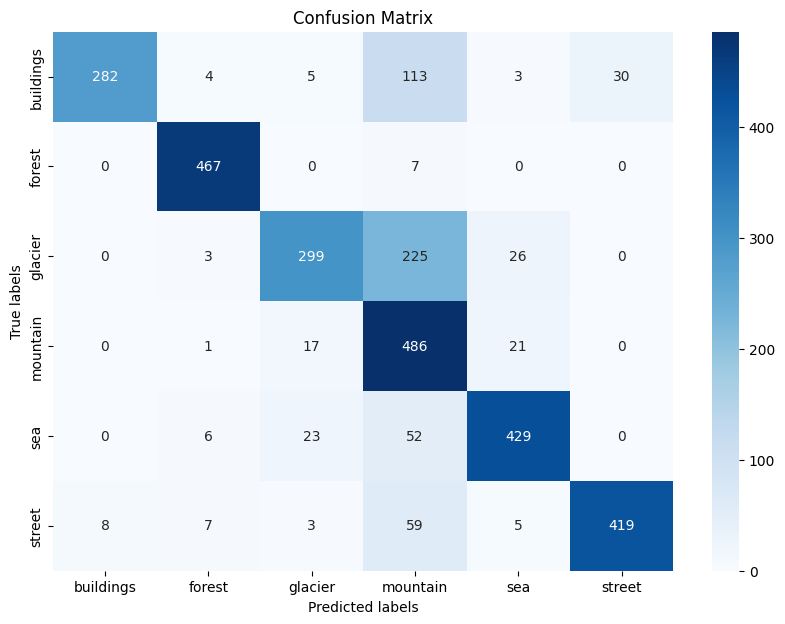

[I 2023-09-30 10:14:30,032] Trial 0 finished with value: 0.7988903260883017 and parameters: {'batch_size': 2, 'learning_rate': 0.09631950307826072, 'beta1': 0.9, 'beta2': 0.997}. Best is trial 0 with value: 0.7988903260883017.
epochs:  20%|██        | 1/5 [01:09<04:36, 69.09s/it]

Epoch 1/5 - Train Loss: 0.4811 - Test Loss: 0.2930 - Train F1: 0.8354 - Test F1: 0.8903


epochs:  40%|████      | 2/5 [01:58<02:52, 57.59s/it]

Epoch 2/5 - Train Loss: 0.2899 - Test Loss: 0.2712 - Train F1: 0.8958 - Test F1: 0.9020


epochs:  60%|██████    | 3/5 [02:32<01:33, 46.65s/it]

Epoch 3/5 - Train Loss: 0.2496 - Test Loss: 0.2663 - Train F1: 0.9095 - Test F1: 0.9017


epochs:  80%|████████  | 4/5 [03:03<00:40, 40.70s/it]

Epoch 4/5 - Train Loss: 0.2253 - Test Loss: 0.2553 - Train F1: 0.9202 - Test F1: 0.9043


epochs: 100%|██████████| 5/5 [03:36<00:00, 43.35s/it]


Epoch 5/5 - Train Loss: 0.2027 - Test Loss: 0.2542 - Train F1: 0.9260 - Test F1: 0.9063
Training finished.


eval: 100%|██████████| 47/47 [00:06<00:00,  6.80it/s]


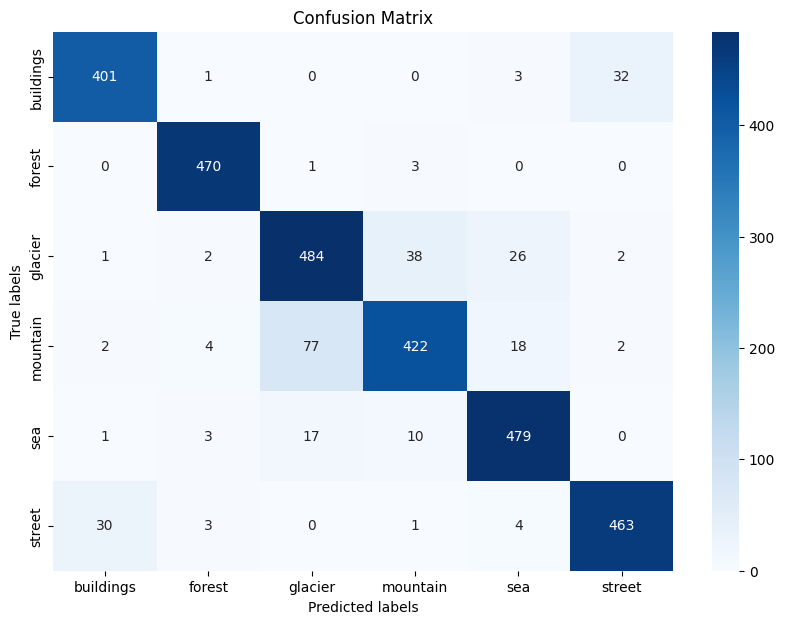

[I 2023-09-30 10:18:14,040] Trial 1 finished with value: 0.9058803531276236 and parameters: {'batch_size': 8, 'learning_rate': 0.000262522149472337, 'beta1': 0.98, 'beta2': 0.996}. Best is trial 1 with value: 0.9058803531276236.
epochs:  20%|██        | 1/5 [00:40<02:43, 40.94s/it]

Epoch 1/5 - Train Loss: 0.6183 - Test Loss: 0.3935 - Train F1: 0.8336 - Test F1: 0.8827


epochs:  40%|████      | 2/5 [01:11<01:44, 34.75s/it]

Epoch 2/5 - Train Loss: 0.3670 - Test Loss: 0.3859 - Train F1: 0.8800 - Test F1: 0.8737


epochs:  60%|██████    | 3/5 [01:48<01:11, 35.86s/it]

Epoch 3/5 - Train Loss: 0.3825 - Test Loss: 0.3763 - Train F1: 0.8794 - Test F1: 0.8827


epochs:  80%|████████  | 4/5 [02:19<00:33, 33.74s/it]

Epoch 4/5 - Train Loss: 0.3606 - Test Loss: 0.4041 - Train F1: 0.8904 - Test F1: 0.8767


epochs: 100%|██████████| 5/5 [02:48<00:00, 33.64s/it]


Epoch 5/5 - Train Loss: 0.3757 - Test Loss: 0.3299 - Train F1: 0.8860 - Test F1: 0.8893
Training finished.


eval: 100%|██████████| 47/47 [00:05<00:00,  8.22it/s]


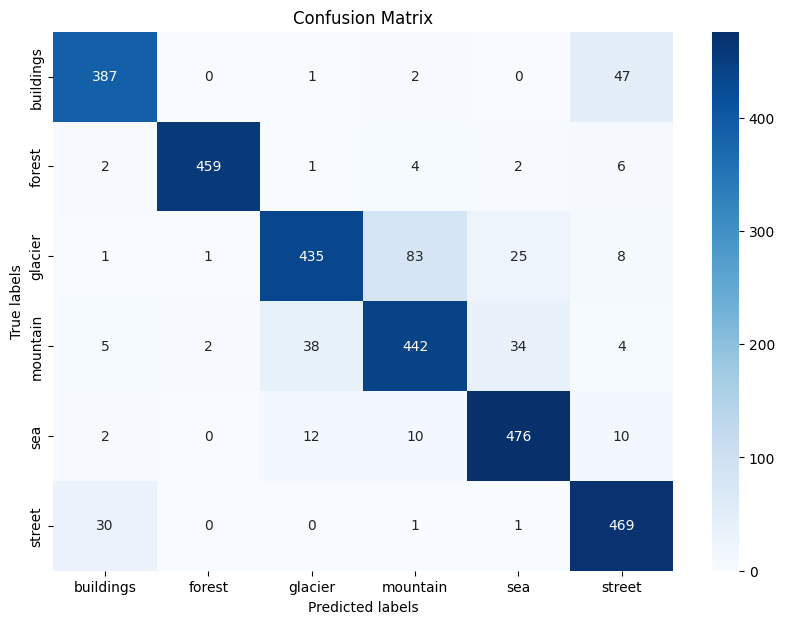

[I 2023-09-30 10:21:08,304] Trial 2 finished with value: 0.8889704183721057 and parameters: {'batch_size': 32, 'learning_rate': 0.01839913565568064, 'beta1': 0.93, 'beta2': 0.995}. Best is trial 1 with value: 0.9058803531276236.
epochs:  20%|██        | 1/5 [00:32<02:11, 32.89s/it]

Epoch 1/5 - Train Loss: 0.4180 - Test Loss: 0.2930 - Train F1: 0.8616 - Test F1: 0.8963


epochs:  40%|████      | 2/5 [01:08<01:43, 34.57s/it]

Epoch 2/5 - Train Loss: 0.2906 - Test Loss: 0.3083 - Train F1: 0.8977 - Test F1: 0.8903


epochs:  60%|██████    | 3/5 [01:44<01:10, 35.01s/it]

Epoch 3/5 - Train Loss: 0.2371 - Test Loss: 0.2842 - Train F1: 0.9150 - Test F1: 0.9013


epochs:  80%|████████  | 4/5 [02:20<00:35, 35.55s/it]

Epoch 4/5 - Train Loss: 0.2074 - Test Loss: 0.3440 - Train F1: 0.9265 - Test F1: 0.8873


epochs: 100%|██████████| 5/5 [02:56<00:00, 35.39s/it]


Epoch 5/5 - Train Loss: 0.1803 - Test Loss: 0.3314 - Train F1: 0.9367 - Test F1: 0.8950
Training finished.


eval: 100%|██████████| 47/47 [00:07<00:00,  6.48it/s]


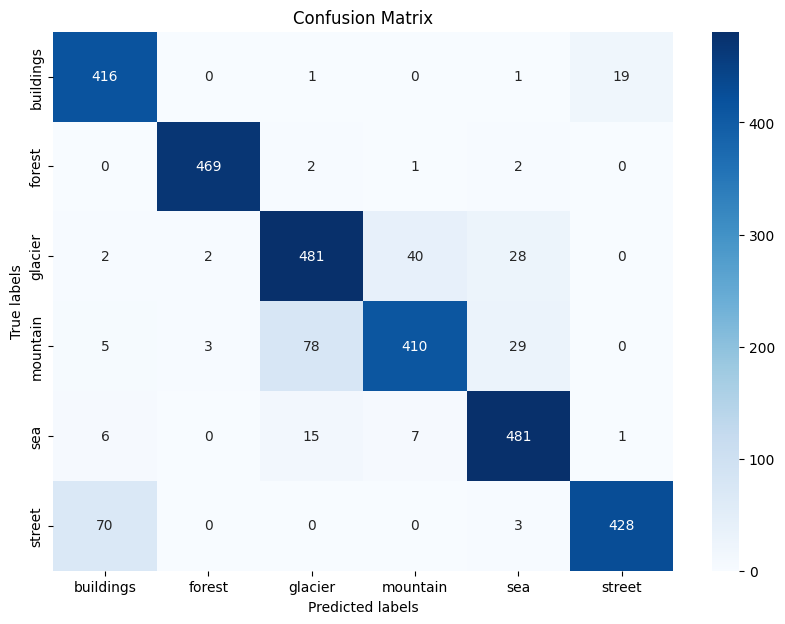

[I 2023-09-30 10:24:12,766] Trial 3 finished with value: 0.8945201693936725 and parameters: {'batch_size': 4, 'learning_rate': 0.005345051707413964, 'beta1': 0.92, 'beta2': 0.996}. Best is trial 1 with value: 0.9058803531276236.
epochs:  20%|██        | 1/5 [01:18<05:13, 78.45s/it]

Epoch 1/5 - Train Loss: 0.5108 - Test Loss: 0.2904 - Train F1: 0.8254 - Test F1: 0.8950


In [6]:
study_name = "Image Classificaion with Transfer Leanring"
study = optuna.create_study(
    study_name=study_name,
    direction="maximize"
    )
study.optimize(objective, n_trials=10)

In [ ]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  10
Best trial:
Value:  0.9249255827687444
Params: 
    batch_size: 6
    learning_rate: 0.001422271973835835
    beta1: 0.92
    beta2: 0.994


In [ ]:
trial.params

{'batch_size': 6,
 'learning_rate': 0.001422271973835835,
 'beta1': 0.92,
 'beta2': 0.994}

epochs:   0%|          | 0/5 [00:00<?, ?it/s]

epochs:  20%|██        | 1/5 [00:47<03:11, 47.78s/it]

Epoch 1/5 - Train Loss: 0.3068 - Test Loss: 0.2048 - Train F1: 0.8939 - Test F1: 0.9270


epochs:  40%|████      | 2/5 [01:32<02:18, 46.17s/it]

Epoch 2/5 - Train Loss: 0.1861 - Test Loss: 0.3235 - Train F1: 0.9369 - Test F1: 0.8887


epochs:  60%|██████    | 3/5 [02:18<01:31, 45.85s/it]

Epoch 3/5 - Train Loss: 0.1289 - Test Loss: 0.2325 - Train F1: 0.9532 - Test F1: 0.9263


epochs:  60%|██████    | 3/5 [03:03<02:02, 61.31s/it]


Epoch 4/5 - Train Loss: 0.0945 - Test Loss: 0.2408 - Train F1: 0.9669 - Test F1: 0.9210
Early stopping triggered.
Training finished.


eval: 100%|██████████| 47/47 [00:07<00:00,  6.08it/s]


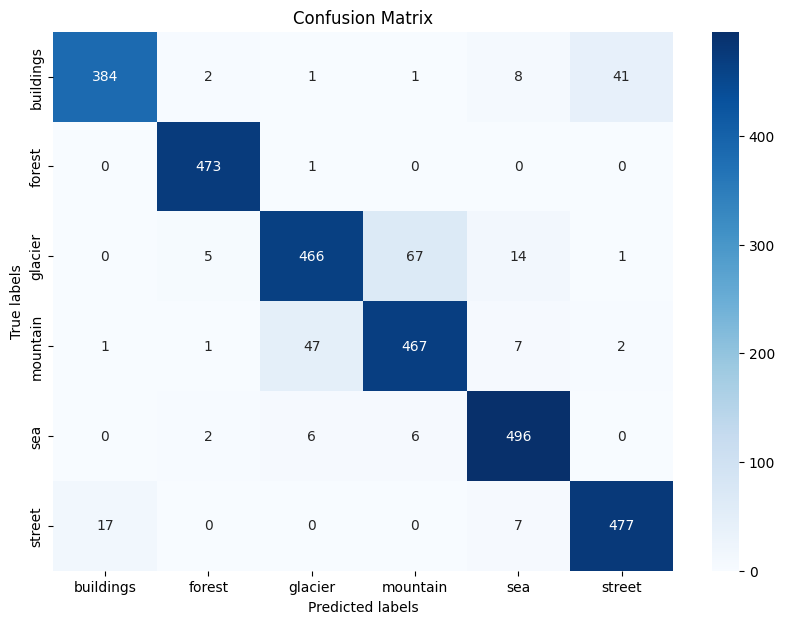

In [ ]:
# Update configs
cfg.beta1 = trial.params['beta1']
cfg.beta2 = trial.params['beta2']
cfg.batch_size = trial.params['batch_size']
cfg.lr = trial.params['learning_rate']


# Create dataloader
data_preparation.create_data_loaders()
trainloader = data_preparation.trainloader
testloader = data_preparation.testloader
cfg.num_classes = data_preparation.num_classes
cfg.class_names = data_preparation.classes_name

# Create Model
model = mobilenetv3_frozen(cfg.num_classes)

# Create Trainer
trainer = Trainer(
    model = model, 
    train_loader=trainloader, 
    test_loader=testloader,
    cfg=cfg
)

optimizer = optim.Adam(model.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))

# Training
trainer.train(
    optimizer=optimizer, 
    scheduler=None,
    criterion=criterion
)
best_model = trainer.model_best_loss
all_predictions, all_true_labels = evaluate_model(
    model=best_model, 
    test_dataloader = testloader, 
    device = cfg.device, 
    class_names = data_preparation.classes_name
)
f1 = f1_score(all_true_labels, all_predictions, average='weighted')

In [ ]:
f1

0.9205463834958723

In [ ]:
torch.save(best_model, 'best_model_tuning.pth')